In [231]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    validation_curve,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    QuantileTransformer,
    FunctionTransformer,
    TargetEncoder,
    MinMaxScaler,
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import scipy as sp

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.compose import TransformedTargetRegressor

import time
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
import re

In [232]:
pd.set_option("display.max_colwidth", None)

In [233]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,1.113943,4.946624,Leisure,None,None,6.858920,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,1.079181,5.015221,Leisure,ServiceFacility,Leisure,6.923655,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,1.623249,5.980508,Leisure,None,None,7.860859,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,1.041393,4.787609,Leisure,None,None,6.832163,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,1.278754,5.244478,Leisure,ServiceFacility,Leisure,7.151450,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,ServiceFacility,47.54067,-122.37441,0.30103,0.301030,4.261548,Leisure,None,None,5.969455,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1533,ServiceFacility,47.59625,-122.32283,0.30103,0.301030,4.204147,Leisure,None,None,5.977850,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1534,ServiceFacility,47.63644,-122.35784,0.30103,0.301030,4.119190,Leisure,ServiceFacility,Leisure,6.760867,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1535,ServiceFacility,47.52832,-122.32431,0.30103,0.301030,4.149281,Leisure,ServiceFacility,School,5.857014,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


In [234]:
energy_data = data.copy()

# Separation of training and test data

In [235]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
    ],
    axis=1,
)

In [236]:
def split():
    return train_test_split(X, y_energy_use, test_size=0.2, random_state=42)

# Pipelines 

Getting a baseline measure with OneHotEncoder

In [237]:
(X_train, X_test, y_train, y_test) = split()

In [238]:
encoder = OneHotEncoder()
encoded_matrix = encoder.fit_transform(
    X_train[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)

X_train = X_train.reset_index()
X_train = X_train.join(df)
X_train.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

encoded_matrix = encoder.transform(
    X_test[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)

X_test = X_test.reset_index()
X_test = X_test.join(df)
X_test.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

In [239]:
def get_linear_regression_scores(X_train, y_train):
    model = LinearRegression()
    model = model.fit(X_train, y_train)

    train_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    test_score = cross_val_score(model, X_test, y_test, cv=5).mean()
    print("Train score: ", train_score)
    print("Test score: ", test_score)

In [240]:
get_linear_regression_scores(X_train, y_train)

Train score:  0.6636507506382983
Test score:  0.4134415292660205


Getting a baseline measure with a custom encoder that condenses all property use types to 6 features representing the categories

In [241]:
(X_train, X_test, y_train, y_test) = split()

In [242]:
encoder = OneHotEncoder()
encoded_matrix = encoder.fit_transform(
    X_train[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)
unique_categories = ["Leisure", "MedicalFacility", "School", "ServiceFacility", "Store"]
grouped = df.groupby(level=0, axis=1).sum()

categorized_properties = grouped[unique_categories]
categorized_properties = categorized_properties.applymap(lambda x: 1 if x > 1 else x)


X_train = X_train.reset_index()
X_train = X_train.join(categorized_properties)
X_train.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

encoded_matrix = encoder.transform(
    X_test[data.select_dtypes(exclude=np.number).columns]
).toarray()

labels = [category for sublist in encoder.categories_ for category in sublist]

df = pd.DataFrame(encoded_matrix, columns=labels)
unique_categories = ["Leisure", "MedicalFacility", "School", "ServiceFacility", "Store"]
grouped = df.groupby(level=0, axis=1).sum()

categorized_properties = grouped[unique_categories]
categorized_properties = categorized_properties.applymap(lambda x: 1 if x > 1 else x)


X_test = X_test.reset_index()
X_test = X_test.join(categorized_properties)
X_test.drop(
    columns=[
        "index",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
    ],
    inplace=True,
)

In [243]:
get_linear_regression_scores(X_train, y_train)

Train score:  0.6509787395261905
Test score:  0.44923921567403624


The train results with OneHotEncoder are slightly better but the test scores are better using the custom encoder

### Testing pipelines

Defining the different possible preprocessing operations

In order to use the custom encoder in a pipeline, we need to create a new CustomOneHotEncoder Class

In [244]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.unique_categories = [
            "Leisure",
            "MedicalFacility",
            "School",
            "ServiceFacility",
            "Store",
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        encoded_array = encoder.fit_transform(X)

        labels = [category for sublist in encoder.categories_ for category in sublist]

        df = pd.DataFrame(encoded_array, columns=labels)
        grouped = df.groupby(level=0, axis=1).sum()

        try:
            categorized_properties = grouped[self.unique_categories]
        except KeyError as e:
            key = re.findall(r"'(.*?)'", e.args[0])[0]
            grouped[key] = 0
            categorized_properties = grouped[self.unique_categories]

        return np.array(categorized_properties.applymap(lambda x: 1 if x > 1 else x))

Let's define the possible preprocessing operations to test in the pipeline:

In [245]:
categorical_features = make_column_selector(dtype_include=object)
numerical_features = make_column_selector(dtype_include=np.number)

onehot_encoder = (
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    categorical_features,
)

custom_onehot = (CustomOneHotEncoder(), categorical_features)

target_encoder = (TargetEncoder(), categorical_features)

We can build a function to compare results of a LinearRegression using different preprocessing steps to determine which combination yields better results 

In [246]:
def compare_pipelines(X, y, model):
    pipelines = {}
    scores = pd.DataFrame()

    for encoder in ["onehot_encoder", "target", "custom"]:
        for selector in ["KBest", "Variance"]:
            if encoder == "onehot_encoder":
                encoder_step = onehot_encoder
            elif encoder == "custom":
                encoder_step = custom_onehot
            elif encoder == "target":
                encoder_step = target_encoder

            if selector == "KBest":
                selector_step = SelectKBest(k=10, score_func=f_regression)
            elif selector == "Variance":
                selector_step = VarianceThreshold(threshold=0.01)

            preprocessor = make_column_transformer(
                encoder_step, remainder="passthrough"
            )

            pipeline = make_pipeline(preprocessor, RobustScaler(), selector_step, model)
            steps = f"{encoder}_{selector}"
            pipelines[steps] = pipeline

    for steps, pipeline in pipelines.items():
        score = cross_val_score(pipeline, X_train, y_train, cv=5).mean()
        scores = pd.concat(
            [
                scores,
                pd.DataFrame({"Pipleline Steps": steps, "R2": score}, index=[0]),
            ],
            ignore_index=True,
        ).sort_values(by="R2", ascending=False)
    ax = sns.barplot(x=scores["R2"], y=scores["Pipleline Steps"])
    for p in ax.patches:
        ax.annotate(
            format(p.get_width(), ".2f"),  # Use get_width() for switched axes
            (
                p.get_x() + p.get_width() / 1.1,
                p.get_y() + p.get_height(),
            ),
            xytext=(0, 15),
            color="white",
            textcoords="offset points",
        )
    plt.show()

In [247]:
(X_train, X_test, y_train, y_test) = split()

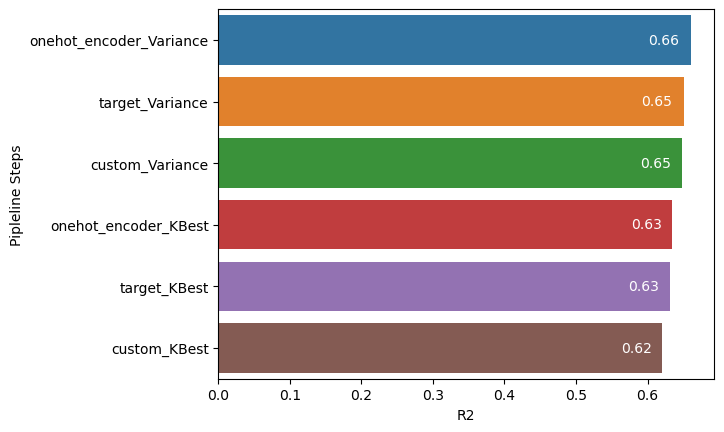

In [248]:
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses the custom OneHotEncoder, and the Variance feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

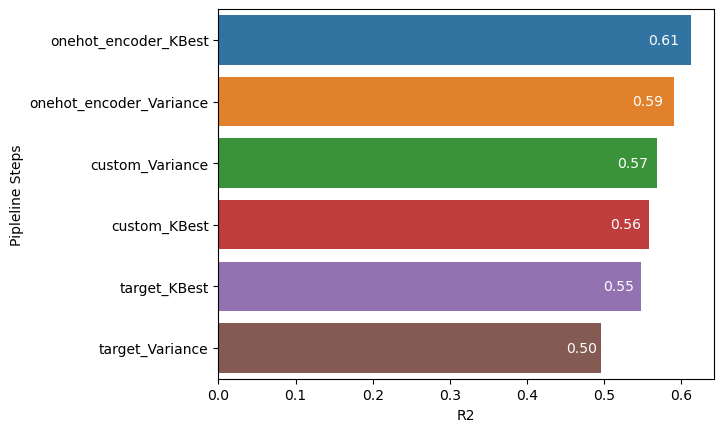

In [249]:
compare_pipelines(X_train, y_train, SVR())

Using SVR, the best score is achieved with OneHotEncoder and the SelectKBest feature selector.

We will test out these selectors with different hyperparameters across different models to see if we can obtain higher scores.

## Comparing metrics 

While MAE is less impacted by outliers, we will favor RMSE since this metric is stricter with large errors.

## Identifying optimal parameters with GridSearchCV

We will compare two pipelines, one using SelectKBest and one with Variance Threshold

In [250]:
(X_train, X_test, y_train, y_test) = split()

In [251]:
def build_pipeline(model, selector):
    return make_pipeline(
        make_column_transformer(onehot_encoder, remainder="passthrough"),
        RobustScaler(),
        selector,
        model,
    )

In [252]:
def grid_search(model, params, selector, comparison_df):
    scoring = {
        "r2": make_scorer(r2_score),
        "neg_mean_squared_error": make_scorer(mean_squared_error),
        "neg_mean_absolute_error": make_scorer(mean_absolute_error),
    }
    start = time.time()

    grid = GridSearchCV(
        build_pipeline(model, selector),
        params,
        cv=5,
        scoring=scoring,
        refit="neg_mean_squared_error",
    )
    grid.fit(X_train, y_train)

    elapsed_time = time.time() - start
    results = {
        "Model": str(model),
        "Selector": str(selector),
        "Mean Fit Time": grid.cv_results_["mean_fit_time"].mean(),
        "Mean R2": grid.cv_results_["mean_test_r2"].mean(),
        "Mean MAE": (grid.cv_results_["mean_test_neg_mean_absolute_error"].mean()),
        "Mean RMSE": (
            np.sqrt((grid.cv_results_["mean_test_neg_mean_squared_error"].mean()))
        ),
        "Best params": str(grid.best_params_),
        "Runtime": elapsed_time,
    }

    results = pd.DataFrame(results, index=[0])
    comparison_df = pd.concat([comparison_df, results], ignore_index=True)
    display(comparison_df)
    return comparison_df

In [253]:
model_comparison = pd.DataFrame()

### SVR

In [254]:
kbest_params = {
    "selectkbest__k": [2, 5, 7, 8, 10, 13, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.3, 0.5, 0.7, 0.9]}

In [255]:
param_grid = {
    "svr__C": [0.1, 0.5, 1, 5],
    "svr__epsilon": [0.5, 1, 2, 5, 10],
}
param_grid.update(kbest_params)

model_comparison = grid_search(SVR(), param_grid, SelectKBest(), model_comparison)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.05456,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463


In [256]:
param_grid = {
    "svr__C": [100, 150, 200, 300],
    "svr__epsilon": [-0.5, 1e-2, 0.5, 1, 2, 5, 10],
}
param_grid.update(variance_params)

model_comparison = grid_search(SVR(), param_grid, VarianceThreshold(), model_comparison)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857


### ElasticNet

In [257]:
param_grid = {
    "elasticnet__alpha": [1, 10, 15, 20],
    "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
    "elasticnet__max_iter": [2000],
}
param_grid.update(kbest_params)

model_comparison = grid_search(
    ElasticNet(), param_grid, SelectKBest(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662


In [258]:
param_grid = {
    "elasticnet__alpha": [1, 10, 15, 20],
    "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
    "elasticnet__max_iter": [2000],
}
param_grid.update(variance_params)

model_comparison = grid_search(
    ElasticNet(), param_grid, VarianceThreshold(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662
3,ElasticNet(),VarianceThreshold(),0.015963,0.265949,0.365345,0.474120,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'variancethreshold__threshold': 0.1}",11.820244


### RandomForest

In [259]:
param_grid = {
    "randomforestregressor__n_estimators": [50, 70, 100, 120],
    "randomforestregressor__max_depth": [1, 10, 20, 50, None],
    "randomforestregressor__min_samples_split": [2, 4, 6],
    "randomforestregressor__max_features": ["sqrt", "log2", None],
}

param_grid.update(kbest_params)

model_comparison = grid_search(
    RandomForestRegressor(), param_grid, SelectKBest(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662
3,ElasticNet(),VarianceThreshold(),0.015963,0.265949,0.365345,0.474120,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'variancethreshold__threshold': 0.1}",11.820244
4,RandomForestRegressor(),SelectKBest(),0.327114,0.578999,0.271177,0.358322,"{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 100, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",2488.575558


In [260]:
param_grid = {
    "randomforestregressor__n_estimators": [100, 120, 150, 200],
    "randomforestregressor__max_depth": [1, 25, 100, None],
    "randomforestregressor__min_samples_split": [1, 2, 4],
    "randomforestregressor__max_features": ["sqrt", "log2", None],
}

param_grid.update(variance_params)

model_comparison = grid_search(
    RandomForestRegressor(), param_grid, VarianceThreshold(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662
3,ElasticNet(),VarianceThreshold(),0.015963,0.265949,0.365345,0.474120,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'variancethreshold__threshold': 0.1}",11.820244
4,RandomForestRegressor(),SelectKBest(),0.327114,0.578999,0.271177,0.358322,"{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 100, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",2488.575558
5,RandomForestRegressor(),VarianceThreshold(),0.235668,0.390912,0.325501,0.431392,"{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'variancethreshold__threshold': 0.9}",2252.785499


### Gradient Boosting

In [261]:
param_grid = {
    "gradientboostingregressor__n_estimators": [120, 150, 200],
    "gradientboostingregressor__loss": [
        "squared_error",
        "absolute_error",
        "huber",
        "quantile",
    ],
    "gradientboostingregressor__min_samples_split": [6, 8, 10],
    "gradientboostingregressor__max_features": ["sqrt", "log2", None],
}

param_grid.update(kbest_params)

model_comparison = grid_search(
    GradientBoostingRegressor(), param_grid, SelectKBest(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662
3,ElasticNet(),VarianceThreshold(),0.015963,0.265949,0.365345,0.474120,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'variancethreshold__threshold': 0.1}",11.820244
4,RandomForestRegressor(),SelectKBest(),0.327114,0.578999,0.271177,0.358322,"{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 100, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",2488.575558
5,RandomForestRegressor(),VarianceThreshold(),0.235668,0.390912,0.325501,0.431392,"{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'variancethreshold__threshold': 0.9}",2252.785499
6,GradientBoostingRegressor(),SelectKBest(),0.276713,0.502175,0.296339,0.389952,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 150, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",1360.543620


In [262]:
param_grid = {
    "gradientboostingregressor__n_estimators": [100, 120, 130, 140],
    "gradientboostingregressor__loss": [
        "squared_error",
        "absolute_error",
        "huber",
        "quantile",
    ],
    "gradientboostingregressor__min_samples_split": [2, 4, 6],
    "gradientboostingregressor__max_features": ["sqrt", "log2", None],
}

param_grid.update(variance_params)

model_comparison = grid_search(
    GradientBoostingRegressor(), param_grid, VarianceThreshold(), model_comparison
)

,Model,Selector,Mean Fit Time,Mean R2,Mean MAE,Mean RMSE,Best params,Runtime
0,SVR(),SelectKBest(),0.054560,0.472508,0.303112,0.401473,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>, 'svr__C': 1, 'svr__epsilon': 2}",50.040463
1,SVR(),VarianceThreshold(),0.034577,0.289433,0.355843,0.466371,"{'svr__C': 150, 'svr__epsilon': 0, 'variancethreshold__threshold': 0.9}",38.776857
2,ElasticNet(),SelectKBest(),0.015745,0.375425,0.330991,0.437142,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",9.163662
3,ElasticNet(),VarianceThreshold(),0.015963,0.265949,0.365345,0.474120,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 2000, 'variancethreshold__threshold': 0.1}",11.820244
4,RandomForestRegressor(),SelectKBest(),0.327114,0.578999,0.271177,0.358322,"{'randomforestregressor__max_depth': 1, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 100, 'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",2488.575558
5,RandomForestRegressor(),VarianceThreshold(),0.235668,0.390912,0.325501,0.431392,"{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'variancethreshold__threshold': 0.9}",2252.785499
6,GradientBoostingRegressor(),SelectKBest(),0.276713,0.502175,0.296339,0.389952,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__n_estimators': 150, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x13f51d5a0>}",1360.543620
7,GradientBoostingRegressor(),VarianceThreshold(),0.194064,0.250847,0.363726,0.478472,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 120, 'variancethreshold__threshold': 0.9}",1192.650779
